In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
one_year = calc_temps('2012-01-01', '2013-01-01')
one_year[0][0]

56.0

NameError: name 'x_axis' is not defined

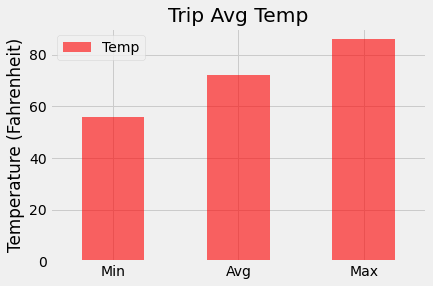

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

one_year_df = pd.DataFrame({"Temp": one_year[0]}, index = ["Min", "Avg","Max"])
one_year_df
one_year_df.plot(kind='bar', color='r', alpha=.6)
plt.title("Trip Avg Temp")
plt.xticks(rotation=0)
plt.ylabel("Temperature (Fahrenheit)")
plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(one_year_df["Temp"])+10)
plt.tight_layout()
plt.show()


### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
year_ago = dt.date(latest_date.year -1, latest_date.month, latest_date.day)

results = session.query(Measurement.station, Station.name, Measurement.prcp, Station.latitude, Station.longitude, Station.elevation, Measurement.date).\
    filter(Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).filter(Measurement.date >= year_ago).all()
results

prcp_df = pd.DataFrame(results, columns=['Station','Name','PRCP','Lat','Lng','Elevation', 'Date'])
prcp_df

,Station,Name,PRCP,Lat,Lng,Elevation,Date
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",6.70,21.33310,-157.80250,152.4,2016-09-14
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",6.25,21.33556,-157.71139,19.5,2017-04-29
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",5.04,21.33556,-157.71139,19.5,2017-02-11
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.00,21.33310,-157.80250,152.4,2017-07-22
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.46,21.33310,-157.80250,152.4,2016-10-04
...,...,...,...,...,...,...,...
2225,USC00516128,"MANOA LYON ARBO 785.2, HI US",NaN,21.33310,-157.80250,152.4,2017-08-06
2226,USC00516128,"MANOA LYON ARBO 785.2, HI US",NaN,21.33310,-157.80250,152.4,2017-08-11
2227,USC00516128,"MANOA LYON ARBO 785.2, HI US",NaN,21.33310,-157.80250,152.4,2017-08-13
2228,USC00516128,"MANOA LYON ARBO 785.2, HI US",NaN,21.33310,-157.80250,152.4,2017-08-18


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals= []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
range_o_dates = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')
range_o_dates
# Strip off the year and save a list of strings in the format %m-%d
no_year = pd.date_range(start_date, end_date).strftime('%m-%d')
no_year
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in no_year:
    temps = daily_normals(date)
    normals.append(temps)

print(normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session